In [22]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset
import dataloader
import numpy as np
import matplotlib.pyplot as plt

In [23]:
batch_size = 64
epochs = 300
device = "cuda"
train_data, train_label, test_data, test_label = dataloader.read_bci_data()

# 自定義dataset
class EEGDataset(Dataset):
    def __init__(self, data, label):
        self.data = torch.tensor(data, device="cuda", dtype=float)
        self.label = torch.tensor(label, device="cuda", dtype=float)
    def __getitem__(self, index):
        return self.data[index], self.label[index]
    def __len__(self):
        return len(self.data)
    

train_dataset = EEGDataset(train_data, train_label)
test_dataset = EEGDataset(test_data, test_label)

# 將dataset丟進dataloader中
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [24]:
# train
def train(train_loader, model, loss_function, optimizer, acc_history):
    model.train()
    train_loss, correct = 0, 0
    for x, y in train_loader:
        pred = model(x)
        loss = loss_function(pred, y.long())
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    correct /= len(train_loader.dataset)
    acc_history.append(correct*100)
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {correct*100:.2f}%")

In [25]:
# test
def test(test_loader, model, loss_function, optimizer, acc_history):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            pred = model(x)
            loss = loss_function(pred, y.long())
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).sum().item()
    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)
    acc_history.append(correct*100)
    print(f"Testing Loss: {test_loss:.4f}, Accuracy: {correct*100:.2f}%")

In [26]:
# EEGNet for ELU
class EEGNet_ELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
        self.flatten = nn.Flatten()

    
    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.flatten(x)
        x = self.classify(x)
        return x



In [27]:
# EEGNet for ReLU
class EEGNet_ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
        self.flatten = nn.Flatten()

    
    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.flatten(x)
        x = self.classify(x)
        return x



In [28]:
# EEGNet for LeakyReLU
class EEGNet_LeakyReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
        self.flatten = nn.Flatten()

    
    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.flatten(x)
        x = self.classify(x)
        return x



In [29]:
%%time
# ELU model
model = EEGNet_ELU().to(device=device, dtype=float)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-02)
elu_train_acc = []
elu_test_acc = []
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    train(train_loader, model, loss_function, optimizer, elu_train_acc)
    test(test_loader, model, loss_function, optimizer, elu_test_acc)
# ReLU model    
model2 = EEGNet_ReLU().to(device=device, dtype=float)
optimizer = optim.Adam(model2.parameters(), lr=1e-02)
relu_train_acc = []
relu_test_acc = []
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    train(train_loader, model2, loss_function, optimizer, relu_train_acc)
    test(test_loader, model2, loss_function, optimizer, relu_test_acc)
# LeakyReLU model
model3 = EEGNet_LeakyReLU().to(device=device, dtype=float)
optimizer = optim.Adam(model3.parameters(), lr=1e-02)
leakyrelu_train_acc = []
leakyrelu_test_acc = []
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    train(train_loader, model3, loss_function, optimizer, leakyrelu_train_acc)
    test(test_loader, model3, loss_function, optimizer, leakyrelu_test_acc)

Epoch: 1
Training Loss: 0.7666, Accuracy: 68.24%
Testing Loss: 0.9481, Accuracy: 66.76%
Epoch: 2
Training Loss: 0.7340, Accuracy: 65.28%
Testing Loss: 0.8027, Accuracy: 67.31%
Epoch: 3
Training Loss: 0.7070, Accuracy: 69.63%
Testing Loss: 0.7946, Accuracy: 70.28%
Epoch: 4
Training Loss: 0.5776, Accuracy: 71.02%
Testing Loss: 0.6912, Accuracy: 70.09%
Epoch: 5
Training Loss: 0.5242, Accuracy: 74.91%
Testing Loss: 0.6244, Accuracy: 72.78%
Epoch: 6
Training Loss: 0.4960, Accuracy: 75.09%
Testing Loss: 0.5906, Accuracy: 72.69%
Epoch: 7
Training Loss: 0.4849, Accuracy: 75.56%
Testing Loss: 0.6253, Accuracy: 72.59%
Epoch: 8
Training Loss: 0.4848, Accuracy: 75.09%
Testing Loss: 0.6133, Accuracy: 71.67%
Epoch: 9
Training Loss: 0.4810, Accuracy: 77.04%
Testing Loss: 0.6154, Accuracy: 72.50%
Epoch: 10
Training Loss: 0.5006, Accuracy: 75.28%
Testing Loss: 0.6151, Accuracy: 72.13%
Epoch: 11
Training Loss: 0.4799, Accuracy: 77.04%
Testing Loss: 0.6374, Accuracy: 70.93%
Epoch: 12
Training Loss: 0.471

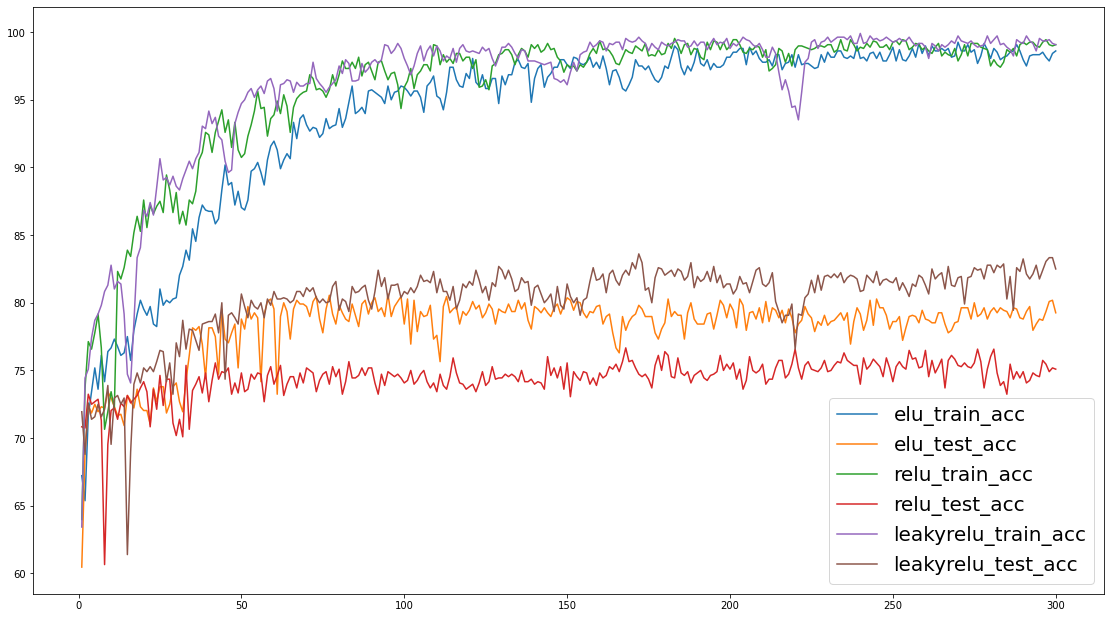

In [9]:
# 畫圖
a = np.arange(1, epochs+1) # x 軸
fig = plt.figure(figsize=(19.2, 10.8)) # 調整size
plt.plot(a, elu_train_acc, label="elu_train_acc")
plt.plot(a, elu_test_acc, label="elu_test_acc")
plt.plot(a, relu_train_acc, label="relu_train_acc")
plt.plot(a, relu_test_acc, label="relu_test_acc")
plt.plot(a, leakyrelu_train_acc, label="leakyrelu_train_acc")
plt.plot(a, leakyrelu_test_acc, label="leakyrelu_test_acc")
plt.legend(loc="lower right", fontsize=20) # 右下標示

In [30]:
# 自定義的Conv2d，將max norm設成2
class Constraint_Conv2d(nn.Conv2d):
    def forward(self, input):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            self.weight, self.bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, self.weight.clamp(max=2), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [31]:
# 自定義的fully connect，將max norm設成0.5
class Constraint_Linear(nn.Linear):
    def forward(self, input):
        return F.linear(input, self.weight.clamp(max=0.5), self.bias)

In [32]:
# DeepConvNet for ELU
class DeepConvNet_ELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.deepconvnet = nn.Sequential(
            Constraint_Conv2d(1, 25, kernel_size=(1, 5), padding="valid"),
            Constraint_Conv2d(25, 25, kernel_size=(2, 1), padding="valid"),
            
            nn.BatchNorm2d(25),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            
            Constraint_Conv2d(25, 50, kernel_size=(1, 5), padding="valid"),
            
            nn.BatchNorm2d(50),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            
            Constraint_Conv2d(50, 100, kernel_size=(1, 5), padding="valid"),
            
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            
            Constraint_Conv2d(100, 200, kernel_size=(1, 5), padding="valid"),
            
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            nn.Flatten(),
            
            Constraint_Linear(8600, 2),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.deepconvnet(x)
        return x

In [33]:
# DeepConvNet for ReLU
class DeepConvNet_ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.deepconvnet = nn.Sequential(
            Constraint_Conv2d(1, 25, kernel_size=(1, 5), padding="valid"),
            Constraint_Conv2d(25, 25, kernel_size=(2, 1), padding="valid"),
            
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            
            Constraint_Conv2d(25, 50, kernel_size=(1, 5), padding="valid"),
            
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            
            Constraint_Conv2d(50, 100, kernel_size=(1, 5), padding="valid"),
            
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            
            Constraint_Conv2d(100, 200, kernel_size=(1, 5), padding="valid"),
            
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            nn.Flatten(),
            
            Constraint_Linear(8600, 2),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.deepconvnet(x)
        return x

In [34]:
# DeepConvNet for LeakyReLU
class DeepConvNet_LeakyReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.deepconvnet = nn.Sequential(
            Constraint_Conv2d(1, 25, kernel_size=(1, 5), padding="valid"),
            Constraint_Conv2d(25, 25, kernel_size=(2, 1), padding="valid"),
            
            nn.BatchNorm2d(25),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            
            Constraint_Conv2d(25, 50, kernel_size=(1, 5), padding="valid"),
            
            nn.BatchNorm2d(50),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            
            Constraint_Conv2d(50, 100, kernel_size=(1, 5), padding="valid"),
            
            nn.BatchNorm2d(100),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            
            Constraint_Conv2d(100, 200, kernel_size=(1, 5), padding="valid"),
            
            nn.BatchNorm2d(200),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5),
            nn.Flatten(),
            
            Constraint_Linear(8600, 2),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.deepconvnet(x)
        return x

In [35]:
%%time
# ELU model
model = DeepConvNet_ELU().to(device=device, dtype=float)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-03)
elu_train_acc = []
elu_test_acc = []
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    train(train_loader, model, loss_function, optimizer, elu_train_acc)
    test(test_loader, model, loss_function, optimizer, elu_test_acc)
# ReLU model
model2 = DeepConvNet_ReLU().to(device=device, dtype=float)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-03)
relu_train_acc = []
relu_test_acc = []
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    train(train_loader, model2, loss_function, optimizer, relu_train_acc)
    test(test_loader, model2, loss_function, optimizer, relu_test_acc)
# LeakyReLU model
model3 = DeepConvNet_LeakyReLU().to(device=device, dtype=float)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=1e-03)
leakyrelu_train_acc = []
leakyrelu_test_acc = []
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    train(train_loader, model3, loss_function, optimizer, leakyrelu_train_acc)
    test(test_loader, model3, loss_function, optimizer, leakyrelu_test_acc)

Epoch: 1
Training Loss: 0.7422, Accuracy: 51.85%
Testing Loss: 0.5938, Accuracy: 69.26%
Epoch: 2
Training Loss: 0.5966, Accuracy: 69.91%
Testing Loss: 0.5890, Accuracy: 70.19%
Epoch: 3
Training Loss: 0.5797, Accuracy: 71.85%
Testing Loss: 0.5777, Accuracy: 72.41%
Epoch: 4
Training Loss: 0.5563, Accuracy: 75.00%
Testing Loss: 0.5707, Accuracy: 72.69%
Epoch: 5
Training Loss: 0.5527, Accuracy: 75.28%
Testing Loss: 0.5835, Accuracy: 71.67%
Epoch: 6
Training Loss: 0.5503, Accuracy: 75.37%
Testing Loss: 0.5825, Accuracy: 71.67%
Epoch: 7
Training Loss: 0.5360, Accuracy: 77.22%
Testing Loss: 0.5650, Accuracy: 73.70%
Epoch: 8
Training Loss: 0.5505, Accuracy: 75.56%
Testing Loss: 0.5832, Accuracy: 71.76%
Epoch: 9
Training Loss: 0.5341, Accuracy: 77.50%
Testing Loss: 0.6226, Accuracy: 67.78%
Epoch: 10
Training Loss: 0.5456, Accuracy: 75.83%
Testing Loss: 0.5700, Accuracy: 73.61%
Epoch: 11
Training Loss: 0.5533, Accuracy: 75.19%
Testing Loss: 0.5749, Accuracy: 72.59%
Epoch: 12
Training Loss: 0.554

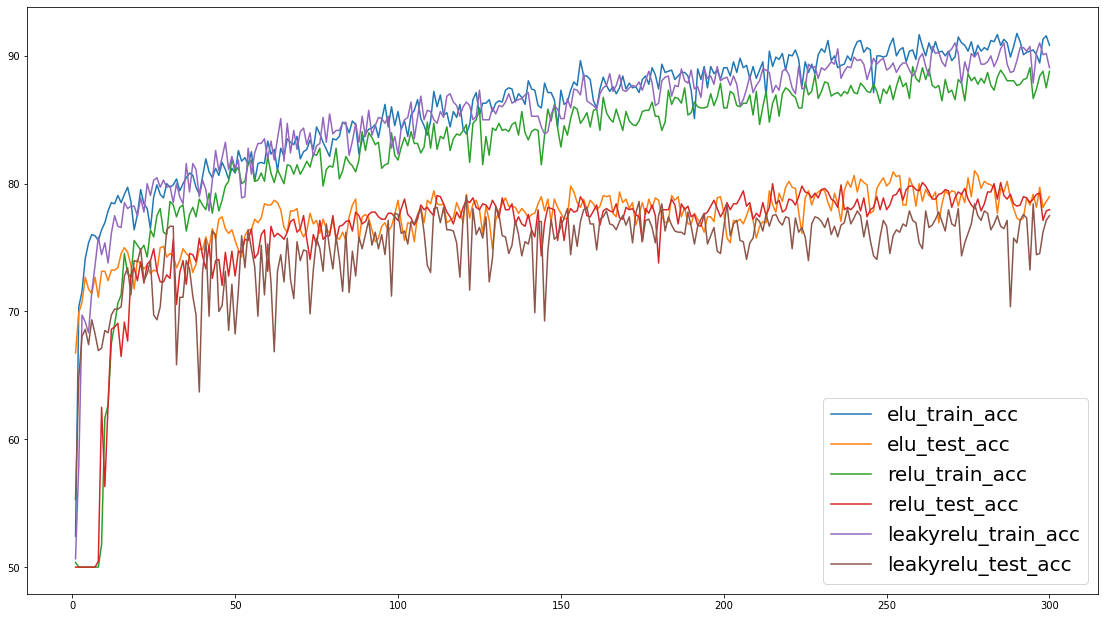

In [19]:
# 畫圖
a = np.arange(1, epochs+1) # x 軸
fig = plt.figure(figsize=(19.2, 10.8)) # 調整size
plt.plot(a, elu_train_acc, label="elu_train_acc")
plt.plot(a, elu_test_acc, label="elu_test_acc")
plt.plot(a, relu_train_acc, label="relu_train_acc")
plt.plot(a, relu_test_acc, label="relu_test_acc")
plt.plot(a, leakyrelu_train_acc, label="leakyrelu_train_acc")
plt.plot(a, leakyrelu_test_acc, label="leakyrelu_test_acc")
plt.legend(loc="lower right", fontsize=20) # 右下標示

# Report
---
## EEGNet
### accuracy:
> 依照EEGNet的格式，分別測試三個不同的activation function，發現leaky relu 的表現較佳<br>
### speed:
> EEGNet跑三種model總共花了4分45秒左右

## DeepConvNet
### accuracy:
> 目測elu表現最好，但三種activation function表現差不多<br>
### speed:
> DeepConvNet跑三種model總共花了10分19秒左右